# Introduction

## New Psychoactive Substances and Machine Learning

### New Psychoactive Substances

According to UNODC, New Psychoactive Substances (NPS) are *substances of abuse, either in a pure form or a preparation, that are not controlled by the 1961 Single Convention on Narcotic Drugs or the 1971 Convention on Psychotropic Substances, but which may pose a public health threat* [[1]](#1).
These compounds present a significant challenge since their potential adverse health effects and social harms are often not documented.

Moreover, *the analysis and identification of a large number of chemically diverse substances present in drug markets at the same time is demanding* [[1]](#1).
Therefore, extensive efforts have been made to develop robust and efficient methods for the detection of NPS.

### Classical approaches to screening NPS

Due to its ease of operation and ability to distinguish compound mixtures, GC–MS is one of the most widely used techniques for substance identification.
Traditionally, the identification of a compound involves matching its retention time and mass spectrum with known records in a library using similarity algorithms. For accurate detection, this approach requires a comprehensive database. However, in the case of NPS, creating an exhaustive database is challenging due to the constantly increasing structural diversity of the substances. Thus, *current GC–MS database are unable to exhaustively cover the spectrum of all possible NPSs* [[2]](#2).

### The machine learning solution

Newer approaches classify unknown substances using machine learning (ML) models trained on compounds in the available library (dataset). These methods are very effective for two reasons:

1. **Pattern recognition**: machine learning algorithms excel at recognizing patterns and trends within complex datasets;
2. **Generalization**: if trained correctly, ML models can generalize the knowledge learned from the available data to new unseen substances, making them particularly suit to detecting substances with always new structures.

An example of this new approach is [[2]](#2), where the authors developed a machine learning based model that can classify an unknown NPS to its drug class based solely on its GC–MS, with no knowledge of its nominal molecular mass.

### The task from the ML perspective

In the machine learning realm, the task of screening new substances given a dataset of known ones is a supervised classification problem. It is a classification problem because the substances need to be either assigned the 'non-NPS' class or one of the known NPS classes. It is called supervised because the substances in the dataset are associated with labels (classes) which guide the ML model's training, acting as supervisors.

There exist several machine learning algorithms that can be used to build a classifier. The effectiveness of these algorithms depend on various factors, including the amount and quality of the available data.

## About the notebook

The goal of this notebook is to demonstrate the effectiveness of machine learning models in screening new psychoactive substances. This has already been proved in [[2]](#2), where, however, only three ML models where tested: a balanced random forest, a deep neural network and a convolutional neural network.

This notebook will use the same GC–MS data employed in [[2]](#2) and test more machine learning models which are not based on neural networks. Moreover, the feature importances of the best performing models will be analysed, which was not done in [[2]](#2).

The following sections will cover the necessary steps for creating an ML model, train multiple models on a dataset with various substances, compare their accuracies and analyse their feature importances.

# The dataset

The dataset used in this notebook is composed of 891 GC–MS spectra of compounds with nominal mass < 600 from various classes. The inputs of the ML models will be the abundances of molecular fragments at mass-to-charge ratios from 1 to 600.

The data can be found under "Appendix D. Supplementary data" of [[2]](#2). As explained by the authors, the dataset was obtained by combining:
1. NPS GC–MS data from the Scientific Working Group for Seized Drug and Cayman Chemical Spectral Library;
2. GC–MS data of other non-related compounds with nominal mass < 600 from the database distributed with the demonstration software version of NIST MS Search v2.3.


# Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid, NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data exploration

Before building ML models, we will explore our dataset in order to understand its characteristics, indentify missing values and check the class distribution. This is necessary to determine the most adequate preprocessing steps.

## Loading the dataset

In [2]:
df = pd.read_csv('Data/1-s2.0-S2468170923000358-mmc1.csv')

In [3]:
print(f'The dataset has {df.shape[0]} instances and {df.shape[1]} features.')

The dataset has 891 instances and 602 features.


In [4]:
df.head()

,Name,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,label
0,1-Phenyl-2-(piperidin-1-yl)butan-1-one,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,"2,3-Dimethylethcathinone",0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,"2,4-Dimethylethcathinone",0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,2-Chloroethcathinone,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,2-Ethylethcathinone,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## Missing values

If the dataset has missing values, we need to address the problem by either removing the incomplete instances (i.e. rows) or filling the missing data with arbitrary or estimated values.

In [5]:
missing_count_rows = df.isnull().sum(axis=1)
missing_count_rows.sort_values(ascending=False, inplace=True)
print(missing_count_rows)

0      0
598    0
587    0
588    0
589    0
      ..
300    0
301    0
302    0
303    0
890    0
Length: 891, dtype: int64


The dataset has no missing values so nothing needs to be done in this regard.

## Class distribution

In classification problems, it's very important to check the class distribution to detect a possible imbalance. Class imbalance occurs when one or more classes significantly outnumber the others. Imbalanced datasets can lead to biased models favouring the majority classes and performing poorly on the minority ones. This occurs because the models are trained to maximize overall accuracy, which might be achieved by predicting the majority class for every instance.

In [6]:
# list of classes
classes = ['Cathinone analogues', 'Cannabinoid analogues',
           'Phenethylamine analogues', 'Piperazine analogues',
           'Tryptamine analogues', 'Fentanyl analogues', 'Other compounds']


# list of distributions
distributions = df['label'].value_counts()

# print frequency per class
for i in range(len(distributions)):
  print(str(distributions[i]) + '\t' + classes[i])

89	Cathinone analogues
149	Cannabinoid analogues
112	Phenethylamine analogues
50	Piperazine analogues
67	Tryptamine analogues
222	Fentanyl analogues
202	Other compounds


The dataset appears to be slightly imbalanced. We will address this issue in the preprocessing phase.

# Preprocessing

Preprocessing is a crucial phase in creating a machine learning model, which consists of cleaning and preparing the raw data before feeding it into a model for training. Usual preprocessing steps include data cleaning, train-test splitting, feature engineering, normalization and handling imbalances.

Since we have no missing values and we will not perform feature engineering, our preprocessing involves:

1. Splitting the dataset into a training one and a testing one;
2. Normalizing the data;
3. Oversampling the data to solve class imbalance.



## Train-test split

The primary goal of a machine learning model is to generalize well to unseen data, in this case unseen NPS. In order to assess this ability, the dataset is split into a training set and a testing set. The models will be trained on the training set and evaluated on the unseen data of the testing set.

Our split will be 80% training and 20% testing.

In [7]:
# separate the target variable ('label') from the rest of the data
Y = df['label']

# drop the target variable and 'Name' in order to only have features
X = df.drop(['label', 'Name'], axis=1)

In [8]:
# save feature names for later
feature_names = X.columns.tolist()

In [9]:
# perform train-test split
X = np.array(X)
Y = np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
# check set sizes
print(f'The training set has {x_train.shape[0]} instances and {x_train.shape[1]} features.')
print(f'The test set has {x_test.shape[0]} instances and {x_test.shape[1]} features.')

The training set has 712 instances and 600 features.
The test set has 179 instances and 600 features.


## Normalization

Many machine learning algorithms are sensitive to the scale of features. Scaling and normalization ensure that all features contribute equally to the model.

We will perform a z-score normalization: the resulting features of the training data will have a mean of 0 and standard deviation of 1.

In [11]:
scaler = StandardScaler()

# fit and transform the training set
x_train = scaler.fit_transform(x_train)

# transform the test set using the same scaler
x_test = scaler.transform(x_test)

## Oversampling

As already verified in the data exploration phase, the dataset is imbalanced. This of course applies to the training set as well. In order to avoid the creation of a biased model, we need to address this issues.

This can be achieved through oversampling, which consists in increasing the number of instances in the minority classes. One way to do so is Synthetic Minority Over-sampling Technique (SMOTE). SMOTE creates synthetic instances for the minority classes by interpolating between the existing ones.


In [12]:
# check if training set is balanced
pd.Series(y_train).value_counts()

5    179
6    165
1    122
2     83
0     70
4     58
3     35
dtype: int64

In [13]:
# oversampling
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [14]:
# check the results
pd.Series(y_train).value_counts()

3    179
6    179
4    179
1    179
5    179
0    179
2    179
dtype: int64

In [15]:
# check set sizes
print(f'The training set has {x_train.shape[0]} instances and {x_train.shape[1]} features.')
print(f'The test set has {x_test.shape[0]} instances and {x_test.shape[1]} features.')

The training set has 1253 instances and 600 features.
The test set has 179 instances and 600 features.


# Model training

We will now train various models on our data with the goal of determining the best performing one. For each model, we will calculate the accuracy on the validation set. This will be useful for comparing the models in the Evaluation section.

## Useful functions

Since the training process is the same for all the models, it's useful to define the following functions, which will reduce the amount of code needed.

### Hyperparameter tuning via grid search

Most machine learning algorithms make use of hyperparameters, parameters that control the learning process.
The optimal hyperparameters can be inferred from the data using a grid search method. Grid search  works by specifying a grid of hyperparameters and corresponding values to explore, and then systematically testing each combination of values on the training data to determine the best performing one.

In [16]:
def grid_search(clf, param_grid, x_train, y_train):
  # perform grid search with cross-validation
  grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(x_train, y_train)

  # display the best parameters and corresponding accuracy
  print("Best parameters: ", grid_search.best_params_)
  print(f"Best cross-validated accuracy: {grid_search.best_score_*100:.2f}%")

  # return the best estimator found
  return grid_search.best_estimator_

### Train and test function

The following function can be used to train and test all the models.

In [17]:
def train_and_test(clf, x_train, y_train, x_test, y_test, param_grid=None):
  # perform hyperparameter tuning if parameters are specified
  if param_grid == None:
    best_clf = clf.fit(x_train, y_train)
  else:
    best_clf = grid_search(clf, param_grid, x_train, y_train)

  # score the model on the test set and display results
  acc = best_clf.score(x_test, y_test)*100
  print(f'Accuracy on validation set: {acc:.2f}%')

  # return the trained model and accuracy metric
  return best_clf, acc

## Models

The following subsections revolve around model training. For each employed model, a brief description is provided.

### Nearest Centroid

Nearest Centroid is one of the simplest classification algorithms. It is based on the idea of representing each class by the centroid (average) of its members in the feature space. During training, the centroids are calculated and, during classification, each new instance is assigned to the class of the closest centroid in feature space.

In [18]:
# train and score Nearest Centroid classifier
clf = NearestCentroid()
nc, nc_acc = train_and_test(clf, x_train, y_train, x_test, y_test)

Accuracy on validation set: 67.04%


### K-Nearest Neighbour

K-Nearest Neighbour (KNN) is another simple algorithm based on closeness. Given a data point to classify, it finds its k nearest neighbours, i.e. the k training examples closest to it in feature space. The predicted class will be the majority (most common) class among the k neighbours.

In [19]:
# train and score K-Nearest Neighbour classifier
nca = NeighborhoodComponentsAnalysis(random_state=42)
clf = KNeighborsClassifier()
nca_pipe = Pipeline([('nca', nca), ('knn', clf)])
knn, knn_acc = train_and_test(nca_pipe, x_train, y_train, x_test, y_test)

Accuracy on validation set: 65.92%


### Gaussian Naive Bayes

Gaussian Naive Bayes is a classification algorithm based on probabilities, which estimates the distribution parameters for each feature in each class from the training data.
When making predictions for a new instance, the algorithm calculates the likelihoods of the observed feature values for each class, combines them with the prior probability of each class and selects the class with the highest overall probability as the prediction.

In [20]:
# train and score Gaussian Naive Bayes classifier
clf = GaussianNB()
gnb, gnb_acc = train_and_test(clf, x_train, y_train, x_test, y_test)

Accuracy on validation set: 68.16%


### Multinomial Logistic Regression

Multinomial logistic regression is an extension of binary logistic regression, which is used for predicting outcomes with two categories. In binary logistic regression the sigmoid function is applied to a linear combination of the features of a given instance, transforming it into the probability of the instance belonging to the first of the two classes. This can be extended to the multinomial case, where more than two categories are present, by training a binary classifier for each class against all the other classes combined (One-vs-Rest approach).

In [21]:
# train and score Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
param_grid = {
    'C' : [0.8, 0.9, 1, 1.1, 1.2]
}
lr, lr_acc = train_and_test(clf, x_train, y_train, x_test, y_test, param_grid)

Best parameters:  {'C': 0.9}
Best cross-validated accuracy: 92.82%
Accuracy on validation set: 76.54%


### Support Vector Machines

Support Vector Machines (SVMs) try to find a hyperplane to separate classes, while trying to maximize the margin, which is the distance between the hyperplane and the nearest data points from each class. These algorithms can handle non-linear relationships between input features by mapping the input data into a higher-dimensional space.

In [22]:
# train and score Support Vector Machine classifier
clf = SVC(random_state=42)
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [0.75, 1, 1.25, 1.5]
}
svm, svm_acc = train_and_test(clf, x_train, y_train, x_test, y_test, param_grid)

Best parameters:  {'C': 1, 'kernel': 'linear'}
Best cross-validated accuracy: 92.34%
Accuracy on validation set: 77.65%


### Decision Tree

A Decision Tree is a tree-like model that makes predictions by recursively splitting the dataset based on features. The goal is to create a tree structure where each internal node represents a decision based on a specific feature and each leaf node represents a classification.

The classification of an instance works as follows: begin at the root node; compare a feature to a threshold and, based on the result, take the left or right branch; repeat until a leaf node is reached; the class associated to the leaf is the predicted one.

In [23]:
# train and score Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [11, 12, 13, 14],
    'min_samples_split' : [2, 3, 4, 5],
    'max_features' : [0.35, 0.4, 0.45, 0.5]
}
dt, dt_acc = train_and_test(clf, x_train, y_train, x_test, y_test, param_grid)

Best parameters:  {'max_depth': 13, 'max_features': 0.4, 'min_samples_split': 2}
Best cross-validated accuracy: 87.31%
Accuracy on validation set: 79.89%


### Random Forest

Random Forest works by building multiple decision trees and training all of them on a random subset of the data. The classification of the random forest model is the average of the classifications of its trees. The usage of multiple trees trained on different data allows random forest to better generalize to unseen data.

In [24]:
# train and score Random Forest classifier
clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators' : [100, 120, 140, 160],
    'max_depth': [8, 9, 10, 11],
    'max_features' : [0.1, 0.2, 0.3]
}
rf, rf_acc = train_and_test(clf, x_train, y_train, x_test, y_test, param_grid)

Best parameters:  {'max_depth': 10, 'max_features': 0.2, 'n_estimators': 140}
Best cross-validated accuracy: 97.05%
Accuracy on validation set: 93.30%


### Extra Trees

The Extra Trees algorithm builds a forest of decision trees just like random forest. However, the thresholds used to evaluate features in the internal nodes are chosen randomly in extra trees; whereas they are optimized in random forests. This increased randomness may result in better generalization.

In [25]:
# train and score Extra Trees classifier
clf = ExtraTreesClassifier(random_state=42)
param_grid = {
    'n_estimators' : [80, 90, 100, 110, 120]
}
extra, extra_acc = train_and_test(clf, x_train, y_train, x_test, y_test, param_grid)

Best parameters:  {'n_estimators': 100}
Best cross-validated accuracy: 97.69%
Accuracy on validation set: 90.50%


### XGBoost

EXtreme Gradient Boosting (XGBoost) is a tree-based algorithm that builds a forest through sequential training. New trees are added to the forest one at the time until a maximum size is reached. Each new learner is built to correct the mistakes of the existing model it is added to.

In [26]:
# train and score XGBoost classifier
clf = XGBClassifier(random_state=42)
param_grid = {
    'max_depth': [6, 7, 8, 9]
}
xgb, xgb_acc = train_and_test(clf, x_train, y_train, x_test, y_test, param_grid)

Best parameters:  {'max_depth': 7}
Best cross-validated accuracy: 97.05%
Accuracy on validation set: 93.85%


### Majority Voting

Multiple ML models can be grouped into an ensemble model in the attempt of achieving a higher accuracy. A simple and common ensemble technique is Majority Voting.
In this kind of model, multiple individual classifiers are trained independently on the same dataset.
When making predictions, each individual model in the ensemble provides its own prediction.
The final prediction of the majority voting model is the class that was voted (predicted) the most.

We will build a majority voting model with our three best performing classifiers.

In [27]:
clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=10, max_features=0.2, n_estimators=140, random_state=42)),
    ('extra', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(max_depth=7, random_state=42))
], voting='soft')

mv, mv_acc = train_and_test(clf, x_train, y_train, x_test, y_test)

Accuracy on validation set: 93.30%


### Stacking model

Another way to combine multiple classifiers is by stacking them. This involves introducing a so called meta-learner, which learns to combine the predictions of the various base classifiers to produce the final classification. Thus, while the base classifiers are trained on the data, the meta-learner is trained on predictions.

We will create a stacking model using our three best performing models as base classifier and an XGBoost as the meta-learner. This requires performing a few operations on the training data, which are done by the functions below.

In [28]:
# function that calculates the predictions on the given data for all the models

def predict_all(models, x_train, x_test):
  train_pred, test_pred = [], []
  for model in models:
    pred = model.predict(x_train)
    train_pred.append(pred)

    pred = model.predict(x_test)
    test_pred.append(pred)

  return train_pred, test_pred

In [29]:
# function to reshape the lists of predictions

def reshape_and_concat(train_pred, test_pred):
  for i in range(len(train_pred)):
    # arrays in each list should be reshaped to be a single column
    train_pred[i] = train_pred[i].reshape(-1, 1)
    test_pred[i] = test_pred[i].reshape(-1, 1)

  # concatenate the columns in each list to obtain a list of rows
  # each row contains the predictions of all the models on a given instance
  # this is what the stacking model will be trained and tested on
  x_train_stk = np.concatenate(train_pred, axis=1)
  x_test_stk = np.concatenate(test_pred, axis=1)

  return x_train_stk, x_test_stk

In [30]:
# function to create stacked representations for both training and testing data

def create_stacking_datasets(models, x_train, x_test):
  # the stacking model is trained and tested on the predictions made by the base models
  train_pred, test_pred = predict_all(models, x_train, x_test)
  # these predictions are slightly formatted
  x_train_stk, x_test_stk = reshape_and_concat(train_pred, test_pred)

  return x_train_stk, x_test_stk

In [31]:
# get the training data necessary for the stacking model
x_train_stk, x_test_stk = create_stacking_datasets([rf, xgb, extra], x_train, x_test)

# we will use XGBoost as our meta-learner
clf = XGBClassifier(random_state=42)

# train the stacking model
param_grid = { 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9] }
stk, stk_acc = train_and_test(clf, x_train_stk, y_train, x_test_stk, y_test, param_grid)

Best parameters:  {'max_depth': 1}
Best cross-validated accuracy: 100.00%
Accuracy on validation set: 93.30%


# Model Evaluation

Now that we have trained all the models, we can compare their accuracies. We will also analyse the confusion matrix of the best model in order to better understand its performance on the test data.

## Accuracy

XGBoost: 93.85%
Stacking: 93.30%
Random Forest: 93.30%
Majority Voting: 93.30%
Extra Trees: 90.50%
Decision Tree: 79.89%
SVM: 77.65%
Logistic Regression: 76.54%
Gaussian Naive Bayes: 68.16%
Nearest Centroid: 67.04%


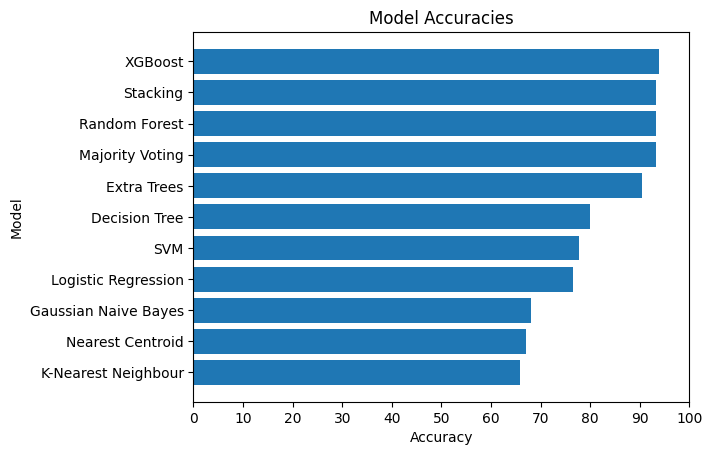

In [32]:
# define the lists with the data to plot
model_names = ['Nearest Centroid', 'K-Nearest Neighbour', 'Logistic Regression',
               'Gaussian Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest',
               'Extra Trees', 'XGBoost', 'Stacking', 'Majority Voting']
accuracies = [nc_acc, knn_acc, lr_acc, gnb_acc, svm_acc, dt_acc, rf_acc,
              extra_acc, xgb_acc, stk_acc, mv_acc]

# sort the lists based on accuracy
sorted_pairs = sorted(zip(accuracies, model_names))
accuracies, model_names = zip(*sorted_pairs)

# print all model-accuracy pairs
for i in range(len(model_names)-1, 0, -1):
  print(model_names[i] + f': {accuracies[i]:.2f}%')

# plot the histogram
plt.barh(model_names, accuracies)
plt.xticks(np.arange(0, max(accuracies) + 10, 10))

# add labels and title
plt.ylabel('Model')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')

plt.show()

Five models achieve an accuracy greater than 90%, with XGBoost and majority voting correctly classifying close to 94% of the test instances. Interestingly the majority voting and stacking models do not manage to achieve an accuracy higher than those of the base classifiers.

## Confusion matrix of the best model (XGBoost)

Despite the high accuracy of the best model, it's important to further analyse its behaviour on the test instances before claiming its effectiveness. In fact, we should verify that all classes are predicted with approximately the same accuracy and that the model can distinguish normal substances from psychoactive ones. This cannot be inferred from accuracy alone, but requires the analysis of the model's confusion matrix.

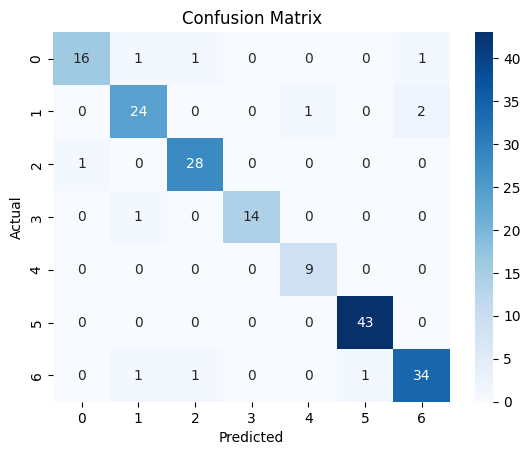

In [33]:
# classify test set
y_pred = xgb.predict(x_test)

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix is almost diagonal, proving that:

1. XGBoost correctly classifies most test instances (already proved by accuracy);
2. All substance types are recognized with high accuracy by XGBoost;
3. XGBoost can distinguish normal substances (class 6) from psychoactive ones (all other classes).

# Feature importance analysis

Feature importance analysis is a technique used in machine learning to understand the significance of different input features in predicting the target variable. It helps identify which features have the most impact on the model's predictions, increasing interpretability. Moreover, knowledge of feature importances can be used to further improve a model by training it only on the significant features.

In our case, we are interested in determining whether all mass-to-charge ratios from 1 to 600 contribute to the best models' classification. The majority voting and stacking models do not provide a measure of feature importance; thus, we will focus on random forest, extra trees and XGBoost.

## Useful functions

The following functions will be used to analyse the models' feature importances.

In [34]:
# returns a list of features whose importances are higher than a threshold

def select_important_features(model, thr=0):
  # get feature importances
  feature_importances = model.feature_importances_

  # zip feature names with their importances and sort in descending order
  feature_importance_dict = dict(zip(feature_names, feature_importances))
  sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

  # select features whose importances are higher than the threshold
  fs = [feature for feature, importance in sorted_feature_importance if importance > thr]

  return fs

In [35]:
# function to plot the distribution of feature importances

def plot_importances_distribution(model, model_name):
  feature_importances = model.feature_importances_
  plt.figure(figsize=(15, 4))
  plt.hist(feature_importances, bins=50, color='skyblue', edgecolor='black')
  plt.xlabel('Importances')
  plt.ylabel('Frequency')
  plt.title('Distribution of feature importances of ' + model_name)
  plt.show()

In [36]:
# function to plot the importance of each feature

def plot_importances_features(model, model_name):
  feature_importances = model.feature_importances_
  plt.figure(figsize=(15, 4))
  plt.bar(feature_names, feature_importances, color='skyblue')
  plt.xlabel('Features')
  plt.ylabel('Importances')
  plt.title('Importance by feature of ' + model_name)
  plt.tick_params(axis='x', colors='white')

## Non-null feature importances

We will begin by counting the features that have a non-null importance for each model.

In [37]:
rf_if = select_important_features(rf)
print('Non-null feature importances for Random forest:', len(rf_if))

Non-null feature importances for Random forest: 375


In [38]:
extra_if = select_important_features(extra)
print('Non-null feature importances for Extra trees:', len(extra_if))

Non-null feature importances for Extra trees: 459


In [39]:
xgb_if = select_important_features(xgb)
print('Non-null feature importances for XGBoost:', len(xgb_if))

Non-null feature importances for XGBoost: 245


As we can see, the number of features that contribute to the models' predictions is considerably lower than 600. In the case of XGBoost, the most overall accurate classifier, less than 50% of the features are used for making a classification.

## Distribution of feature importances

Despite already knowing that a lot features have null importance, we are interested in determining whether some of the remaining features have an importance so small that they can be considered insignificant. We can determine this by plotting the distribution of feature importances.

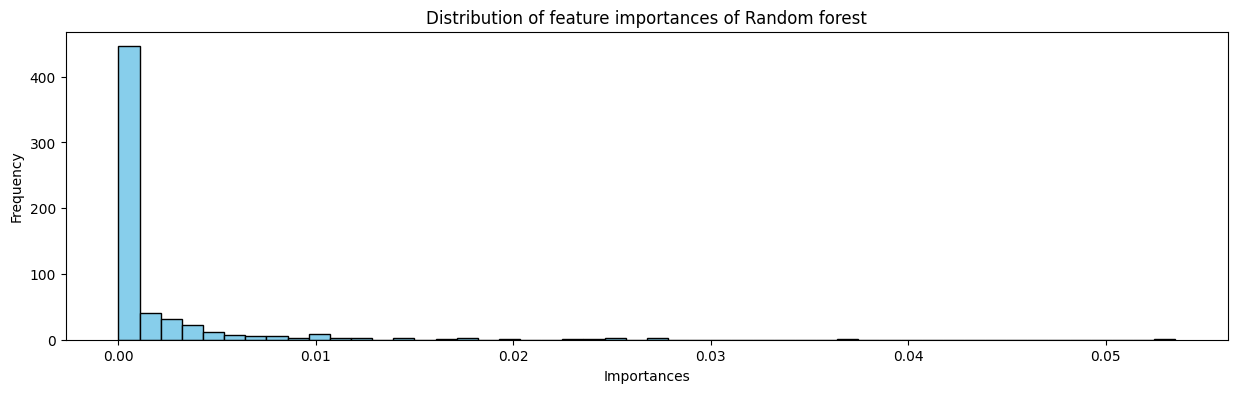

In [40]:
plot_importances_distribution(rf, 'Random forest')

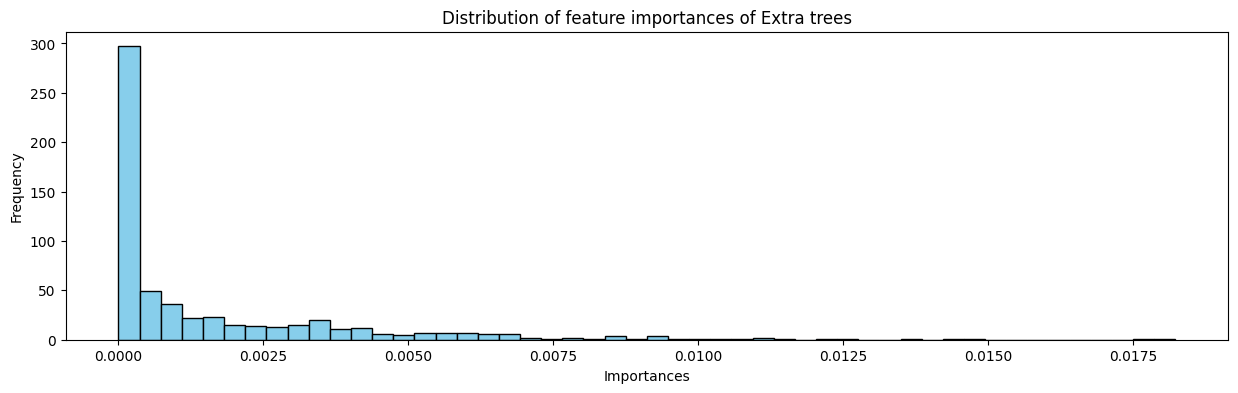

In [41]:
plot_importances_distribution(extra, 'Extra trees')

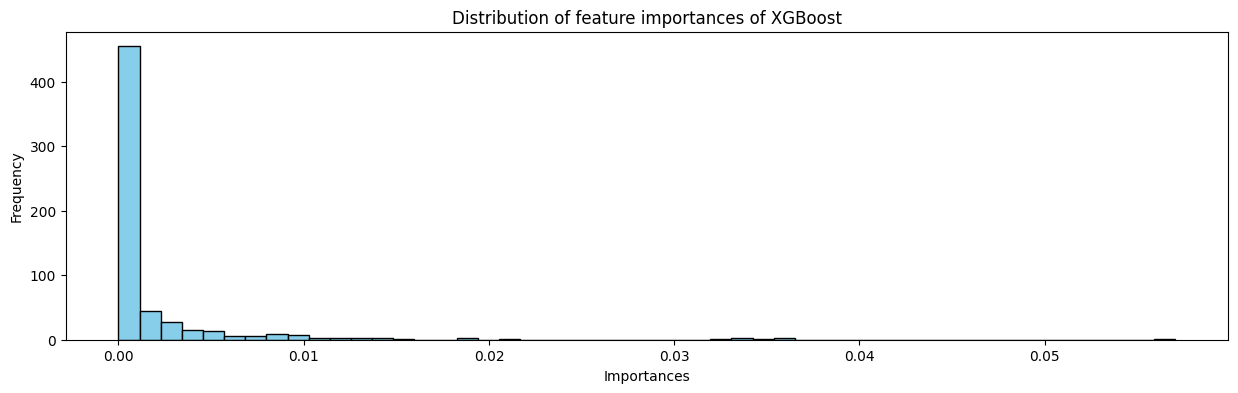

In [42]:
plot_importances_distribution(xgb, 'XGBoost')

## Importance by feature

Now that we have verified that a lot of features have either zero importance or a very little one, we should determine which features actually contribute the most to the models' predictions. We can do this by plotting the feature importances of each model.

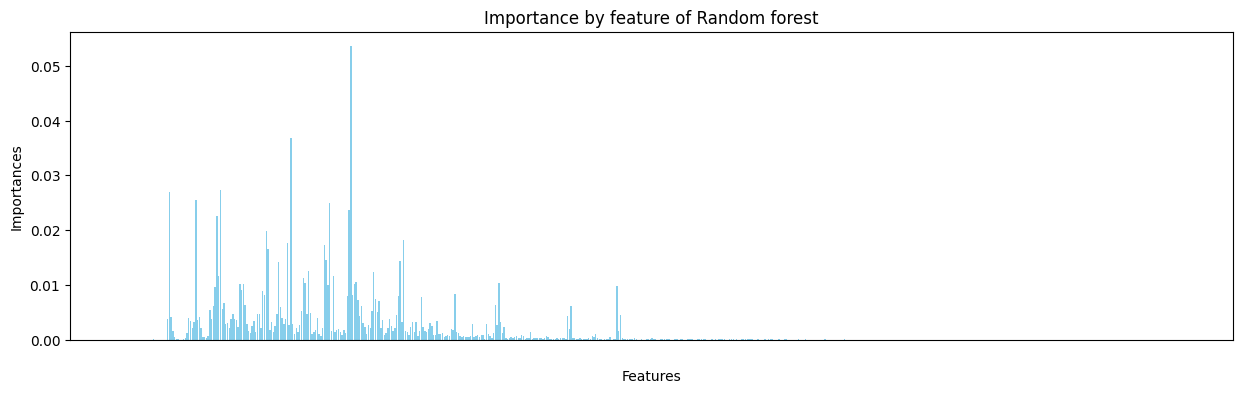

In [43]:
plot_importances_features(rf, 'Random forest')

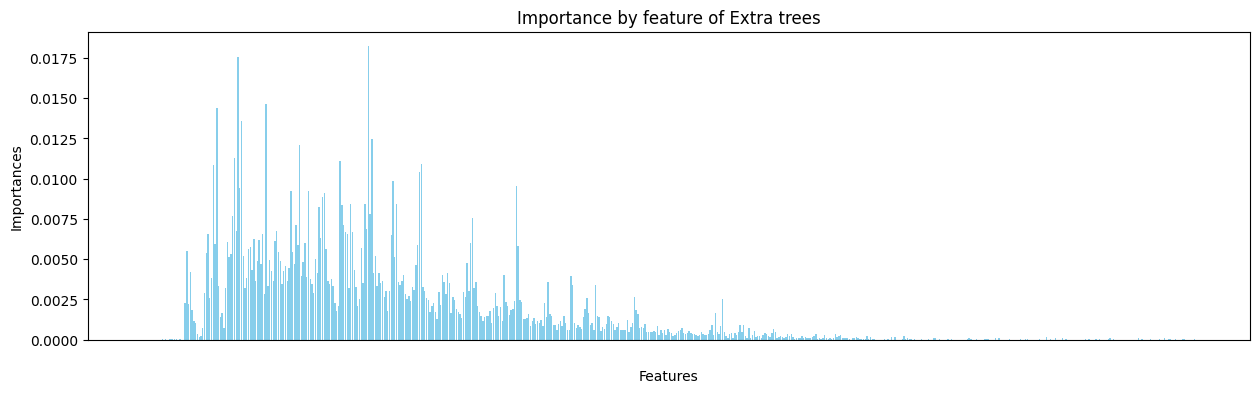

In [44]:
plot_importances_features(extra, 'Extra trees')

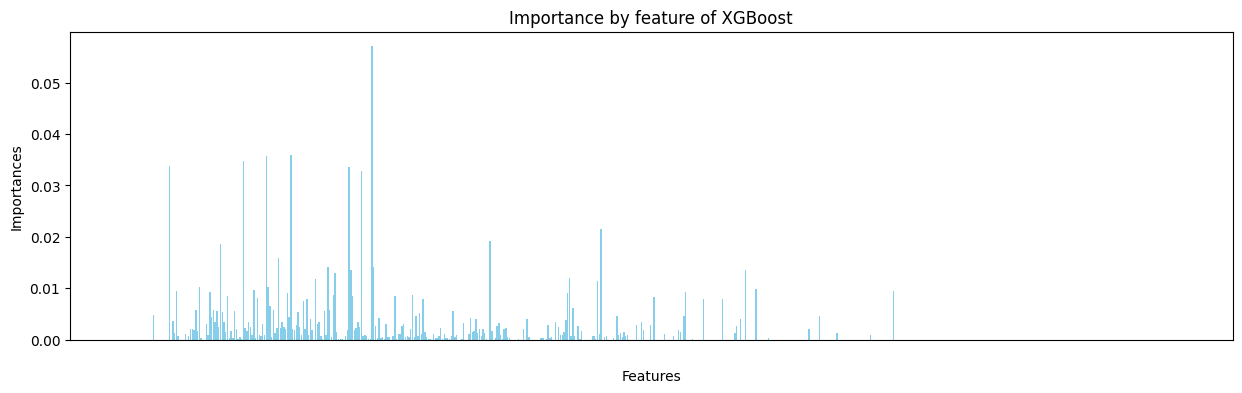

In [45]:
plot_importances_features(xgb, 'XGBoost')

As we can see in the graphs, it is usually the abundances of molecular fragments at relatively low mass-to-charge ratios that have the highest feature importances. This implies that a good classification accuracy could be achieved even if only this data were available.

# Re-training XGBoost on most important features

Now that we know that less than half of the features influence the prediction of the best model (XGBoost), we should train and evaluate the model using only the subset of features with a non-null importance.

## Training

In [46]:
# convert array of feature names into array of feature indices
# feature 'i' has index i-1
feature_indices = np.array(xgb_if).astype(int) - np.ones(len(xgb_if)).astype(int)

# extract new training and testing sets based on the feature indices
x_train_if = x_train[:, feature_indices]
x_test_if = x_test[:, feature_indices]

# check
print('Shape of reduced training set:', x_train_if.shape)
print('Shape of reduced testing set:', x_test_if.shape)

Shape of reduced training set: (1253, 245)
Shape of reduced testing set: (179, 245)


In [47]:
# train and score XGBoost classifier
clf = XGBClassifier(random_state=42)
param_grid = {
    'max_depth': [9, 10, 11]
}
xgb, xgb_acc = train_and_test(clf, x_train_if, y_train, x_test_if, y_test, param_grid)

Best parameters:  {'max_depth': 10}
Best cross-validated accuracy: 97.13%
Accuracy on validation set: 93.30%


## Confusion matrix

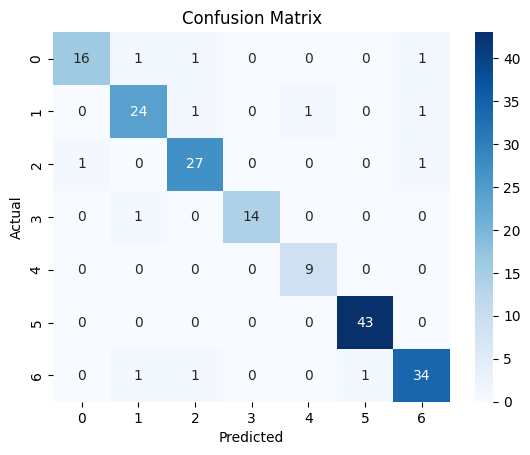

In [48]:
# classify test set
y_pred = xgb.predict(x_test_if)

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The 93.30% accuracy and the very diagonal confusion matrix prove that the 245 features with non-null importances are sufficient to build a very accurate XGBoost model.

# Conclusions

This notebook proved the effectiveness of machine learning models in classifying unknown substances solely based on their GC-MS spectra.
The best performing algorithm found is XGBoost, which achieved an overall accuracy of 93.85%. Very high accuracies were also scored by the decision tree ensemble methods, i.e. random forest (93.30%) and extra trees (90.50%). Combining these models through majority voting (93.85%) and stacking (93.30%) did not result in higher accuracies.

The analysis of the confusion matrix also verified that the XGBoost model recognizes all substance classes with high accuracy and can distinguish normal compounds from NPS, proving the model is not biased.

Finally, the analysis of the feature importances for the random forest, extra trees and XGBoost models highlighted that a large subset of the 600 features does not contribute to the predictions and that the most significant features are the abundances of molecular fragments at relatively low mass-to-charge ratio. Re-training XGBoost on the subset of 245 features with non-null importances resulted in an overall 93.30% accuracy.


# Bibliography

<a name="1"></a>[1] United Nations on Drugs and Crime (UNODC) - Early Warning Advisory on New Psychoactive Substances. https://www.unodc.org/LSS/Page/NPS

<a name="2"></a>[2] Wong, S. L., Ng, L. T., Tan, J., & Pan, J. (2023). Screening unknown novel psychoactive substances using GC–MS based machine learning. *Forensic Chemistry*, 34, 100499.